**novelty detection**:
The training data is not polluted by outliers, and we are interested in detecting anomalies in new observations.

**outlier detection**:
The training data contains outliers, and we need to fit the central mode of the training data, ignoring the deviant observations.

In [1]:
!source activate py2

/bin/sh: activate: No such file or directory


In [2]:
#!/anaconda3/envs/py2/bin/pip install cvxopt

In [3]:
import numpy as np
from cvxopt import solvers, lapack, matrix, spmatrix
solvers.options['show_progress'] = 0
import matplotlib.pyplot as plt
import matplotlib as mpl
% matplotlib inline

## Generate Data

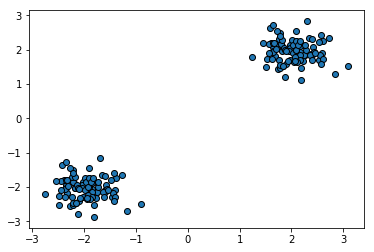

In [4]:
X = 0.3 * np.random.randn(100, 2)
X = np.r_[X + 2, X - 2]

#X = np.random.multivariate_normal([0,0],np.eye(2), 200)

def plot(X):
    plt.scatter(X[:,0], X[:,1], edgecolors  = 'black')
    pass

plot(X)


## Algorithms

### Basic solution : solving the dual by Quadratic Programming

\begin{aligned}
& \min_\alpha \frac{1}{2} \sum_{i,j} \alpha_i\alpha_j k(x_i,x_j) \\
& s.t. \ 0 \leq \alpha_i \leq \frac{1}{n \nu}, \ \sum_i \alpha_i = 1
\end{aligned}
In matrix form : 
\begin{aligned}
& \min_\alpha \frac{1}{2} \alpha^\top K \alpha \\ & s.t. \ 0 \leq \alpha \leq \frac{1}{n\nu}, \ 1^\top \alpha = 1
\end{aligned}

QP in standard form :

\begin{aligned}
& \min_x \frac{1}{2} x^\top P x + q^\top x \\
& s.t. \ Gx \leq h, \ Ax = b
\end{aligned}

In [5]:
def RBF_Kernel(X, sigma2, Y = None):
    " Compute the RBF kernel matrix of X"
    from sklearn.metrics.pairwise import euclidean_distances
    
    if type(Y)==type(None):
        Y = X
    
    K = euclidean_distances(X,Y, squared=True)
    K *= -1./sigma2
    K = np.exp(K)
    return K

In [29]:
def Poly_Kernel(X, d, c, Y=None):
    if type(Y)==type(None):
        Y = X.copy()
    K = ( np.dot(X,Y.T) +c)**d
    #from sklearn.metrics.pairwise import polynomial_kernel
    #K = polynomial_kernel(X,Y,degree=d,coef0=c)
    return(K)

In [7]:
def fit(X, nu, kernel):  #kernel is a list [kernel_type,sigma/d,c]
    n = X.shape[0]
    if kernel[0] == 'RBF':
        sigma2 = kernel[1]
        K = RBF_Kernel(X, sigma2)
    else:
        d, c = kernel[1:]
        K = Poly_Kernel(X,d,c)

    P = matrix(K, tc = 'd')
    q = matrix([0]*n, tc = 'd')
    G = matrix(np.concatenate([np.eye(n),-np.eye(n)], axis = 0), tc = 'd')
    h_value = [1./(n * nu)]*n
    h_value.extend([0]*n)
    h = matrix(h_value, tc = 'd')
    A = matrix(np.reshape([1]*n, (1,n)), tc = 'd')
    b = matrix(1, tc = 'd')
    
    sol = solvers.qp(P,q,G,h,A,b)
    alpha = np.array(sol['x'])
    ix_in = np.where((alpha > 1e-5) & (alpha < 1./(n*nu)))[0][0]
    rho = np.transpose(np.dot(np.reshape(alpha, (1,n)), K[:,ix_in]))

    return alpha, rho

def predict(X, newData, alpha, rho, kernel):
    n = X.shape[0]
    if kernel[0] == 'RBF':
        sigma2 = kernel[1]
        K = RBF_Kernel(X, sigma2, newData)
    else:
        d, c = kernel[1:]
        K = Poly_Kernel(X,d,c,Y=newData)
    return np.transpose(np.dot(np.reshape(alpha, (1,n)), K) - rho)

In [8]:
def get_grid(X, step = 0.05):
    x_axis = np.arange(min(X[:,0])-step,max(X[:,0])+2*step,step)
    y_axis = np.arange(min(X[:,1])-step,max(X[:,1])+2*step,step)

    my_grid = []
    for i in x_axis:
        for j in y_axis:
            my_grid.append([i,j])#,1])
    my_grid = np.array(my_grid)
    
    return x_axis, y_axis, my_grid

def Normalize_Pred(pred):    
    pred_100 = pred -np.min(pred)
    pred_100 = (pred_100 / np.max(pred_100)) * 100
    return pred_100

def get_delim(pred_100, x_axis, y_axis, eps = 0):
    ix_delim = np.where((pred_100  < eps) & (pred_100  > -eps))[0]
    x_delim = []
    y_delim = []
    for i in range(len(ix_delim)):
        a, b = np.divmod(ix_delim[i],len(y_axis))
        x_delim.append(x_axis[a])
        y_delim.append(y_axis[b])
    return x_delim, y_delim

def plot_pred(X, x_axis, y_axis, pred_100, x_delim, y_delim, step = 0.05):
    norm_colors = mpl.colors.Normalize(vmin=0,vmax=100)
    X_axis, Y_axis = np.meshgrid(x_axis, y_axis)
    C = np.transpose(pred_100.reshape((len(x_axis), len(y_axis))))
    plt.pcolor(X_axis, Y_axis, C, norm= norm_colors, cmap = 'YlOrRd')
    plt.scatter(x_delim, y_delim, c = 'blue', s = 10)
    plot(X)
    plt.xlim((min(X[:,0])-step,max(X[:,0])+step))
    plt.ylim((min(X[:,1])-step,max(X[:,1])+step))
    pass

def plot_pred_plan(X, alpha, rho, kernel, step = 0.05, eps = 0):
    x_axis, y_axis, my_grid = get_grid(X, step)
    pred = predict(X, my_grid, alpha, rho, kernel)
    x_delim, y_delim = get_delim(pred, x_axis, y_axis, eps)
    pred_100 = Normalize_Pred(pred)
    #print("pred100",pred_100.shape)
    plot_pred(X, x_axis, y_axis, pred_100, x_delim, y_delim, step)
    return pred

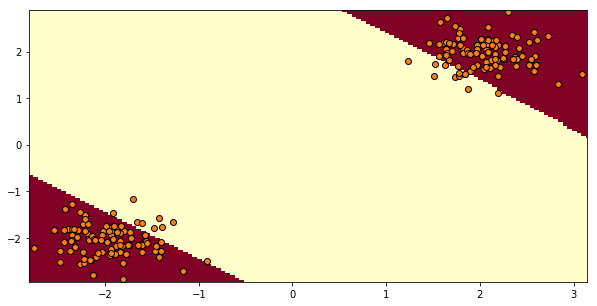

In [9]:
step = 0.05
nu = 0.1
sigma2 =1

kernel = ['Poly',2,1]
alpha, rho = fit(X, nu, kernel)
#predict(X,X,alpha,rho,kernel)


plt.figure(figsize=(10,5))
#plt.subplot(1,2,1)
pred = plot_pred_plan(X, alpha, rho, kernel, step = step)

#pred = predict(X,X,alpha,rho,kernel)
#plt.subplot(1,2,2)
x_axis, y_axis, my_grid = get_grid(X, step = step)
pred_bin = np.sign(pred)
pred_100 = Normalize_Pred(pred_bin)
x_delim, y_delim = get_delim(pred_100, x_axis, y_axis, eps = 0)
plot_pred(X, x_axis, y_axis, pred_100, x_delim, y_delim, step = step)

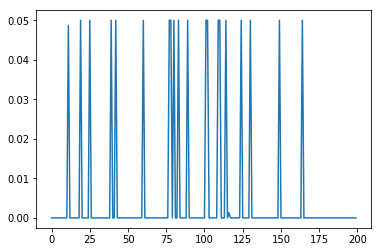

In [10]:
plt.plot(alpha)

## Artifical data

In [46]:
X = np.random.normal(0,0.1,size=[200,2])
X_2class = np.random.normal(1,0.05,size=[20,2])

X2 = np.concatenate((X,X_2class),axis=0)

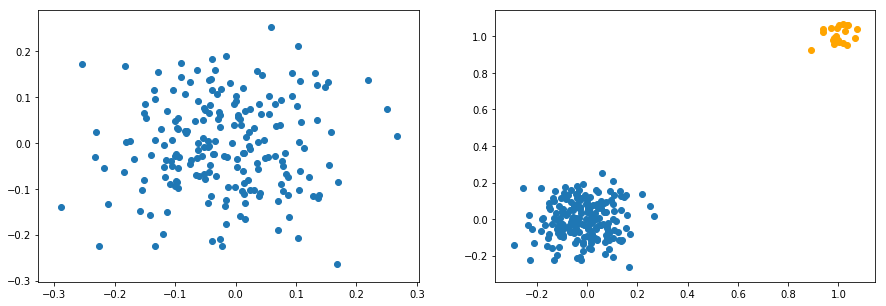

In [47]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.scatter(X[:,0],X[:,1])
plt.subplot(122)
plt.scatter(X[:,0],X[:,1])
plt.scatter(X_2class[:,0],X_2class[:,1],c='orange')
plt.show()

In [ ]:
step = 0.01
nu = [0.1,0.05]


plt.figure(figsize=(20,15))


####### RBF ########

sigma2=0.5

plt.subplot(2,3,1)
nu=0.1
kernel = ['RBF',sigma2]
alpha, rho = fit(X, nu, kernel)
plt.title('kernel RBF \n'+r'$ \nu =$'+str(nu)+r'  $\sigma^2 =$'+str(sigma2)+r' $\rho$ = '+\
 str(np.round(rho[0],2)),fontsize=15)
x_axis, y_axis, my_grid = get_grid(X, step = step)
pred = plot_pred_plan(X, alpha, rho, kernel, step = step)
pred_bin = np.sign(pred)
pred_100 = Normalize_Pred(pred_bin)
x_delim, y_delim = get_delim(pred_100, x_axis, y_axis, eps = 0)
plot_pred(X, x_axis, y_axis, pred_100, x_delim, y_delim, step = step)
                       

plt.subplot(2,3,2)
kernel = ['RBF',sigma2]
nu=0.1
alpha, rho = fit(X2, nu, kernel)
plt.title('Kernel RBF \n'+r'$ \nu =$'+str(nu)+r'  $\sigma^2 =$'+str(sigma2)+r' $\rho$ = '+\
 str(np.round(rho[0],2)),fontsize=15)
x_axis, y_axis, my_grid = get_grid(X2, step = step)
pred = plot_pred_plan(X2, alpha, rho, kernel, step = step)
pred_bin = np.sign(pred)
pred_100 = Normalize_Pred(pred_bin)
x_delim, y_delim = get_delim(pred_100, x_axis, y_axis, eps = 0)
plot_pred(X2, x_axis, y_axis, pred_100, x_delim, y_delim, step = step)

plt.subplot(2,3,3)
nu=0.3
kernel = ['RBF',sigma2]
alpha, rho = fit(X2, nu, kernel)
plt.title('Kernel RBF \n'+r'$ \nu =$'+str(nu)+r'  $\sigma^2 =$'+str(sigma2)+r' $\rho$ = '+\
 str(np.round(rho[0],2)),fontsize=15)
x_axis, y_axis, my_grid = get_grid(X2, step = step)
pred = plot_pred_plan(X2, alpha, rho, kernel, step = step)
pred_bin = np.sign(pred)
pred_100 = Normalize_Pred(pred_bin)
x_delim, y_delim = get_delim(pred_100, x_axis, y_axis, eps = 0)
plot_pred(X2, x_axis, y_axis, pred_100, x_delim, y_delim, step = step)


#### POLYNOMIAL  #######
d=2
c=5*10**(-1)

plt.subplot(2,3,4)
nu=0.1
kernel = ['Poly',d,c]
alpha, rho = fit(X, nu, kernel)
plt.title('kernel Polynomial \n'+r'$ \nu =$'+str(nu)+' d = '+str(d)+r' $\rho$ = '+\
 str(np.round(rho[0],2)),fontsize=15)
x_axis, y_axis, my_grid = get_grid(X, step = step)
pred = plot_pred_plan(X, alpha, rho, kernel, step = step)
pred_bin = np.sign(pred)
pred_100 = Normalize_Pred(pred_bin)
x_delim, y_delim = get_delim(pred_100, x_axis, y_axis, eps = 0)
plot_pred(X, x_axis, y_axis, pred_100, x_delim, y_delim, step = step)                    

plt.subplot(2,3,5)
nu=0.1
kernel = ['Poly',d,c]
alpha, rho = fit(X2, nu, kernel)
plt.title('kernel Polynomial \n'+r'$ \nu =$'+str(nu)+' d = '+str(d)+r' $\rho$ = '+\
 str(np.round(rho[0],2)),fontsize=15)
x_axis, y_axis, my_grid = get_grid(X2, step = step)
pred = plot_pred_plan(X2, alpha, rho, kernel, step = step)
pred_bin = np.sign(pred)
pred_100 = Normalize_Pred(pred_bin)
x_delim, y_delim = get_delim(pred_100, x_axis, y_axis, eps = 0)
plot_pred(X2, x_axis, y_axis, pred_100, x_delim, y_delim, step = step)

plt.subplot(2,3,6)
nu=0.95
kernel = ['Poly',d,c]
alpha, rho = fit(X2, nu, kernel)
plt.title('kernel Polynomial \n'+r'$ \nu =$'+str(nu)+' d = '+str(d)+r' $\rho$ = '+\
 str(np.round(rho[0],2)),fontsize=15)
x_axis, y_axis, my_grid = get_grid(X2, step = step)
pred = plot_pred_plan(X2, alpha, rho, kernel, step = step)
pred_bin = np.sign(pred)
pred_100 = Normalize_Pred(pred_bin)
x_delim, y_delim = get_delim(pred_100, x_axis, y_axis, eps = 0)
plot_pred(X2, x_axis, y_axis, pred_100, x_delim, y_delim, step = step)

#plt.show()
plt.savefig('fake_data_plot')

### testing K means

In [49]:
class OCC:
    
    def __init__(self, X, step = 0.05, eps = 0):
        import matplotlib.pyplot as plt
        import numpy as np
        
        self.X = X
        self.n = X.shape[0]
        self.figsize = (10,5)
        
        # plot parameters
        self.step = step
        self.eps = eps
        self.norm_colors = mpl.colors.Normalize(vmin=0,vmax=100)
        self.set_grid()
        
        pass
    
    # Plot functions
    
    def plot(self):
        plt.scatter(self.X[:,0], self.X[:,1], edgecolors  = 'black')
        plt.xlim((min(self.X[:,0])-self.step,max(self.X[:,0])+self.step))
        plt.ylim((min(self.X[:,1])-self.step,max(self.X[:,1])+self.step))
        pass
    
    def set_grid(self):
        self.x_axis = np.arange(min(self.X[:,0])-self.step,max(self.X[:,0])+2*self.step,self.step)
        self.y_axis = np.arange(min(self.X[:,1])-self.step,max(self.X[:,1])+2*self.step,self.step)

        self.my_grid = []
        for i in self.x_axis:
            for j in self.y_axis:
                self.my_grid.append([i,j])
        self.my_grid = np.array(self.my_grid)

        pass

    def Normalize_Pred(self):    
        self.pred_100 = self.pred -np.min(self.pred)
        self.pred_100 = (self.pred_100 / np.max(self.pred_100)) * 100
        pass

    def set_delim(self):
        ix_delim = np.where((self.pred  < self.eps) & (self.pred  > -self.eps))[0]
        self.x_delim = []
        self.y_delim = []
        for i in range(len(ix_delim)):
            a, b = np.divmod(ix_delim[i],len(self.y_axis))
            self.x_delim.append(self.x_axis[a])
            self.y_delim.append(self.y_axis[b])
        pass

    def plot_pred(self, pred):
        
        X_axis, Y_axis = np.meshgrid(self.x_axis, self.y_axis)
        C = np.transpose(pred.reshape((len(self.x_axis), len(self.y_axis))))
        plt.pcolor(X_axis, Y_axis, C, norm = self.norm_colors, cmap = 'YlOrRd')
        plt.scatter(self.x_delim, self.y_delim, c = 'black', s = 10)
        self.plot()
        pass

    def plot_pred_plan(self):
        self.pred = self.predict(self.my_grid)
        self.pred_bin = np.sign(self.pred)
        self.set_delim()
        self.Normalize_Pred()
        
        plt.figure(figsize=self.figsize)
        plt.subplot(1,2,1)
        self.plot_pred(self.pred_100)
        plt.subplot(1,2,2)
        self.plot_pred((self.pred_bin+1)*100)
        pass
    
    
    # Skeletons for fit and predict
    def fit(self):
        pass
    
    def predict(self):
        pass
    
    # Others methods
    def RBF_Kernel(self, X, sigma2, Y = None):
        " Compute the RBF kernel matrix of X"
        from sklearn.metrics.pairwise import euclidean_distances

        if type(Y)==type(None):
            Y = X

        K = euclidean_distances(X,Y, squared=True)
        K *= -1./sigma2
        K = np.exp(K)
        return K

In [176]:
class OkMeans(OCC):
    " Visual Object Recognition through One-Class Learning \
      QingHua Wang, Luís Seabra Lopes, and David M. J. Tax "
    
    def fit(self, thresh, k, kernel = False):
        from sklearn.cluster import KMeans
        
        self.thresh = thresh
        self.k = k
        self.kernel = kernel
        if kernel:
            K = self.RBF_Kernel(self.X, 1)            
        else:
            K = self.X

        kmeans = KMeans(n_clusters=k).fit(K)
        self.centers = kmeans.cluster_centers_
        
        pass
    
    def predict(self, newData):
        from sklearn.metrics.pairwise import euclidean_distances
        if self.kernel:
            newData = np.transpose(self.RBF_Kernel(self.X, 1, newData))
        D = euclidean_distances(newData, self.centers, squared=True)
        D = np.min(D, axis = 1)
        pred = -D + self.thresh
        return pred

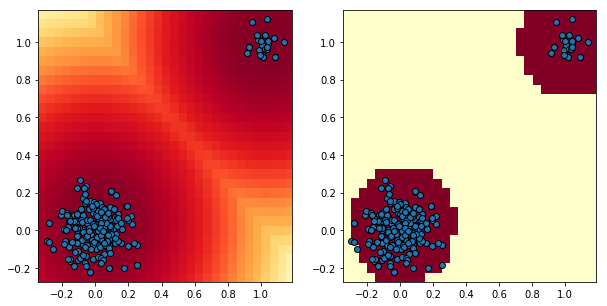

In [189]:
kmeans = OkMeans(X2)

kmeans.fit(0.1,k=2)

pred = kmeans.predict(X2)

kmeans.plot_pred_plan()

## Application to real data

### Stamps data

In [30]:
import pandas as pd
df = pd.read_csv("stamps.txt",sep="\t",header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9
0,0.112011,0.425226,0.424364,0.681209,0.748623,0.066976,0.865725,0.020741,0.181869,1
1,0.000000,0.425226,0.043612,0.086249,0.122159,0.000000,0.889814,1.000000,0.969187,1
2,0.119357,0.425226,0.280526,0.587800,0.696619,0.014433,0.980303,0.367449,0.595861,1
3,0.024987,0.425226,0.056383,0.097072,0.130242,0.001800,0.787256,0.284758,0.804989,1
4,0.176667,0.425226,0.356267,0.515091,0.555632,0.059072,0.881087,0.006373,0.124229,1


data source: http://cs.au.dk/~barbora/outDet.html

In [31]:
print("% of outlier:",len(df[df[9]==1])/len(df))

% of outlier: 0.09117647058823529


In [32]:
# DATA PREP
X=np.array(df.iloc[:,:9])
y=np.array(df.iloc[:,9])
y[y==1]=-1
y[y==0]=1

#split the data into train/test
ind = np.random.choice(np.arange(0,len(X)),int(len(X)*0.7),replace=False)
ind_test = np.setdiff1d(np.arange(0,len(X)),ind)
#separate the data in train and test
X_test,y_test=X[ind_test,:],y[ind_test]
X_train,y_train=X[ind,:],y[ind]

In [33]:
nu=0.08
sigma2=2
kernel = ['RBF',sigma2]
alpha, rho = fit(X_train, nu, kernel)

In [34]:
y_pred = np.sign(predict(X_train, X_test, alpha, rho, kernel)).flatten()

In [35]:
print("share of outliers on test set:",len(y_test[y_test==-1])/len(y_test))

share of outliers on test set: 0.08737864077669903


In [36]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[ 5  4]
 [10 84]]
             precision    recall  f1-score   support

         -1       0.33      0.56      0.42         9
          1       0.95      0.89      0.92        94

avg / total       0.90      0.86      0.88       103



### Letter recognition dataset

data source: http://odds.cs.stonybrook.edu/letter-recognition-dataset/

In [37]:
from scipy.io import loadmat
x = loadmat('letter.mat')
X=x['X']
y=x['y'].flatten()
y=y.astype(float)
X=X.astype(int)
y[y==1]=-1
y[y==0]=1
#split the data into train/test
ind = np.random.choice(np.arange(0,len(X)),int(len(X)*0.7),replace=False)
ind_test = np.setdiff1d(np.arange(0,len(X)),ind)
#separate the data in train and test
X_test,y_test=X[ind_test,:],y[ind_test]
X_train,y_train=X[ind,:],y[ind]

In [38]:
nu=0.05
sigma2=0.5*256
kernel = ['RBF',sigma2]
alpha, rho = fit(X_train, nu, kernel)
y_pred = np.sign(predict(X_train, X_test, alpha, rho, kernel)).flatten()

In [39]:
from sklearn.metrics import confusion_matrix, classification_report
conf=confusion_matrix(y_test,y_pred)
print(conf)
print(classification_report(y_test,y_pred))
print("false positive rate:",np.round(conf[1,0]/np.sum(conf),2))

[[  6  19]
 [ 54 401]]
             precision    recall  f1-score   support

       -1.0       0.10      0.24      0.14        25
        1.0       0.95      0.88      0.92       455

avg / total       0.91      0.85      0.88       480

false positive rate: 0.11


In [43]:
from sklearn.metrics import f1_score

def cross_val(list_sigma2,list_nu,X_train,X_test):
    t=0
    list_score = []
    for nu_val in list_nu:
        for sigma2_val in list_sigma2:
            kernel = ['RBF',sigma2_val]
            alpha, rho = fit(X_train, nu_val, kernel)
            y_pred = np.sign(predict(X_train, X_test, alpha, rho, kernel)).flatten()
            #minimize false negatives ?
            list_score.append([nu_val,sigma2_val,f1_score(y_test,y_pred)] )
            t=t+1
        print(100*t/(len(list_nu)*len(list_sigma2)))
    return(list_score)

def best_score(list_score):
    scores = [n[2] for n in list_score]
    index = np.argmax(scores)
    return(list_score[index][0:2])


In [44]:
#cross validation
list_nu=np.arange(0.1,0.8,0.1)
list_sigma2=np.arange(30,100,10)

list_score = cross_val(list_nu,list_sigma2,X_train,X_test)
nu_best, sigma2_best = best_score(list_score)
kernel = ['RBF',sigma2_best]

#final model
alpha, rho = fit(X_train, nu_best, kernel)
y_pred = np.sign(predict(X_train, X_test, alpha, rho, kernel)).flatten()

nu_best =0.1
sigma2_best = 90

from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

KeyboardInterrupt: 